In [42]:
#explore what the paper is saying
#describe all params exactly as given
#follow along and see where it leads

#watch stanford cs221 2019 mdp lecs


In [43]:
#TODOLIST cuz apparently todo in caps is a keyword
#figure out how to store info in the env and call it while training
#otherwise epilepsy graph

In [44]:
import numpy as np
import math
import gymnasium as gym
from gym import Env
from gym import spaces
import random
import numpy as np
from IPython.display import clear_output
import os
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#device setup
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [45]:
# freq_agile_radar_versions = [[9 * math.pow(10, 9), 10* math.pow(10, 9)]]

# interval = (freq_agile_radar_versions[0][1] - freq_agile_radar_versions[0][0])/64
# print (interval)

# hop_states = []
# for i in range (0,64):
    
#     hop_states.append(int(freq_agile_radar_versions[0][0]+ interval * i))

# print (hop_states)
# print (len(hop_states))


In [46]:
hop_states = [9e9, 9e9 + 20e6, 9e9 + 40e6, 9e9 + 60e6, 9e9 + 80e6, 9e9 + 100e6, 9e9 + 120e6, 9e9 + 140e6]

In [47]:
# Equation:     JPr    =     ((PJ x GJ x GR x lam2 x BWR)     /     ((4 x pi)2 x R2J x BWJ x L))
#  JPr        = Jam Power at Receiver (Watt)
#  PJ         = Jammer Transmitted Power (Watt)
#  GJ         = Antenna Gain of Jammer (Figure)
#  GJR        = Antenna Gain of Radar (Figure)
#  lam       = Wavelength (m)
#  BWR     = IF Bandwidth Radar (Hz)
#  RJ         = Range to Jammer (m)
#  BWJ     = Jamming Bandwidth
#  L          = Losses
#  BWR and BWJ are matched no Losses!

In [48]:
jam_power = 1
g_j = 1
g_jr = 1
lambda_j = 1
bw_j = 1
bw_r = 1
r_j = 1
losses = 1

k = bw_r/(bw_j * losses)

#effective jam power at radar receiver

jam_power_eff = (jam_power * g_j * g_jr * np.power(lambda_j,2) * k)/(4 * np.pi * np.power(r_j, 2))
print (jam_power_eff)

transmitted_power = 1
g_t = 1 #antenna gain of transmitter
lambda_s = 1 #wavelength of signal
delta = 1
r_s = 1 #range to signal

#signal power at radar receiver

signal_power = (transmitted_power * np.power(g_t, 2) * np.power(lambda_s, 2) * delta)/(4 * np.power(np.pi, 3) * np.power(r_s, 4))
print(signal_power)

# k_aj is the suppression coeff
# when jam_power_eff/signal_power > k_aj, the jamming is effective

jsr = jam_power_eff/signal_power #jam to signal ratio

jsr_eff = jsr * bw_j/bw_r #effective jsr


0.07957747154594767
0.008062883608299874


In [49]:
class RadarJammingEnv(gym.Env):
    def __init__(self, hop_states, max_hop_length=8):
        super(RadarJammingEnv, self).__init__()

        # radar params
        self.p_j = 1 #power of jamming signal
        self.g_j = 1 #antenna gain of jammer
        self.l_pj = 1 #path loss of jamming signal from jammer to radar
        self.p_s = 1 #power of radar signal
        self.g_r = 1 #antenna gain of radar
        self.l_ps = 1 #path loss from radar to the target
        self.dist = 1 #distance bw the radar and the target
        self.bw_j = 1 #bandwidth of the jammer
        self.bw_r = 1 #bandwidth of the radar

        #all available freqs
        self.hop_states = hop_states
        self.low = self.hop_states[0]
        self.interval = self.hop_states[1] - self.hop_states[0]
        self.n_frequencies = len(hop_states)

        #maximum num choices for the radar hopping sequence
        self.max_hop_length = max_hop_length
        
        #action space
        self.action_space = spaces.Discrete(self.max_hop_length)
        
        #observation space for current radar freq used
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_frequencies,), dtype=np.float32)
        
        #init hopping patter
        self.hopping_pattern = self.generate_hopping_pattern ()
        self.current_step = 0
        
        #radar frequency used in this step
        self.current_frequency = self.next_frequency ()

        #cumulative reward
        self.cumulative_reward = 0
    
    def index_to_action(self, index):
        return int(self.low + index * self.interval)

    def calc_eff_jsr (self):

        eff_jsr = (self.p_j * self.g_j * self.l_pj * self.bw_j)/(self.p_s * self.g_r * self.l_ps * self.bw_r)
        return eff_jsr
        
    def generate_hopping_pattern (self):

        #random sequence of length max_hop_length hop states
        hopping_pattern = np.random.choice(self.hop_states, self.max_hop_length, replace=False)
        #hopping_pattern = [self.hop_states[i] for i in [1, 0, 3, 2, 5, 4, 7, 6]]
        return hopping_pattern

    
    def next_frequency (self):

        return self.hopping_pattern[self.current_step % self.max_hop_length]
    
    def reset(self):

        self.hopping_pattern = self.generate_hopping_pattern ()
        self.current_frequency = self.next_frequency ()
        self.current_step = 0
        self.cumulative_reward = 0
        info = {}
        
        return self.get_observation(), info
    
    def get_observation (self):

        #observation is a one-hot encoded vector of the current radar frequency
        observation = np.zeros(self.n_frequencies)
        freq_index = np.where(self.hop_states == self.current_frequency)[0][0]
        observation[freq_index] = 1
        return observation
    
    def step(self, action):

        if self.current_step == 0:
            print ("Starting Simulation")
            print ('\n')
        
        done = False
        reward = 0

        #calc range within which the jammer is effective
        lower_bound = self.index_to_action(action) - 10e6
        upper_bound = self.index_to_action(action) + 10e6
        
        # check if the current radar frequency is within the jammer's range
        freq_index = np.where(self.hop_states == self.current_frequency)[0][0]

        #this will store the correct frequency used in this step
        self.frequency_used = self.current_frequency
        
        if lower_bound <= self.hop_states[freq_index] <= upper_bound:

            reward = 100

        else:
            reward = -50

        self.current_step += 1
        self.cumulative_reward += reward
        #updating the frequency for the next step
        self.current_frequency = self.next_frequency ()
        
        #end episode
        if self.current_step >= 100:
            done = True
        
        return self.get_observation (), reward, done, {}
    
    def render(self, mode='human'):
        displayed_action = self.index_to_action(action)
        print(f"Step: {self.current_step},  Radar Frequency: {self.frequency_used},   Action: {displayed_action}")


In [50]:
print (hop_states)
env = RadarJammingEnv(hop_states)

obs = env.reset()
done = False

cumulative_reward = 0
while not done:
    
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    cumulative_reward += reward
    env.render()
    print(f"Action: {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")
    print ('\n')


[9000000000.0, 9020000000.0, 9040000000.0, 9060000000.0, 9080000000.0, 9100000000.0, 9120000000.0, 9140000000.0]
Starting Simulation


Step: 1,  Radar Frequency: 9000000000.0,   Action: 9020000000
Action: 1, Reward: -50, Cumulative Reward: -50


Step: 2,  Radar Frequency: 9120000000.0,   Action: 9080000000
Action: 4, Reward: -50, Cumulative Reward: -100


Step: 3,  Radar Frequency: 9020000000.0,   Action: 9040000000
Action: 2, Reward: -50, Cumulative Reward: -150


Step: 4,  Radar Frequency: 9100000000.0,   Action: 9080000000
Action: 4, Reward: -50, Cumulative Reward: -200


Step: 5,  Radar Frequency: 9080000000.0,   Action: 9080000000
Action: 4, Reward: 100, Cumulative Reward: -100


Step: 6,  Radar Frequency: 9040000000.0,   Action: 9140000000
Action: 7, Reward: -50, Cumulative Reward: -150


Step: 7,  Radar Frequency: 9060000000.0,   Action: 9100000000
Action: 5, Reward: -50, Cumulative Reward: -200


Step: 8,  Radar Frequency: 9140000000.0,   Action: 9140000000
Action: 7, Reward: 1

In [51]:
#setting up replay memory

Transition = namedtuple('Transition',
('state', 'action', 'next_state', 'reward')
)

In [52]:
class ReplayMemory (object):

    def __init__(self, capacity):

        self.memory = deque([], maxlen = capacity)

    def push (self, *args):

        # save a transition
        self.memory.append(Transition(*args))

    def sample (self, batch_size):

        return random.sample (self.memory, batch_size)

    def __len__ (self):

        return len(self.memory)

In [53]:
class DQN (nn.Module):

    def __init__ (self, n_observations, n_actions):

        super (DQN, self).__init__()

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear (128, n_actions)

    def forward (self, x):

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))

        return self.layer3(x)

In [54]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
print (env.reset())
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(2000)


steps_done = 0

(array([0., 0., 0., 1., 0., 0., 0., 0.]), {})


In [55]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [56]:
episode_rewards = []

In [57]:
def plot_rewards(show_result=False):
    plt.figure()
    plt.ion()
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    
    #100-episode moving average for rewards
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.00001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [58]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [59]:
# cumulative_reward = 0
# count = 1
# while not done:
#     action = env.action_space.sample()
#     obs, reward, done, info = env.step(action)
#     info[count] = env.cumulative_reward

#     cumulative_reward += reward
#     env.render()
#     print(f"Action: {action}, Reward: {reward}, Cumulative Reward: {cumulative_reward}")
#     print ('\n')

In [60]:
print (torch.cuda.is_available())

True


Complete


<Figure size 640x480 with 0 Axes>

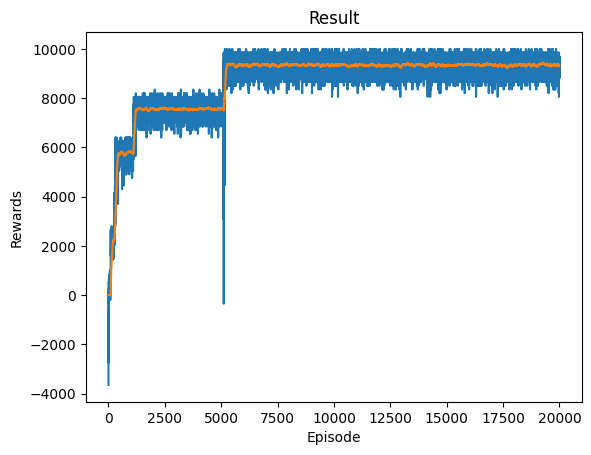

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [61]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 20000
else:
    num_episodes = 500

plt.ion()

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    #t is the step number
    #count is the iterator over num steps
    cumulative_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        cumulative_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(cumulative_reward)
            plot_rewards()

            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()